In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config IPCompleter.greedy=True

## Создание csv с данными о типах блюд в чеках по дням

#### Загрузим тренировочные данные

In [2]:
train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919985 entries, 0 to 919984
Data columns (total 6 columns):
chknum       919985 non-null object
person_id    919985 non-null int64
month        919985 non-null int64
day          919985 non-null int64
good         919985 non-null object
good_id      919985 non-null int64
dtypes: int64(4), object(2)
memory usage: 42.1+ MB


In [3]:
train.head()

,chknum,person_id,month,day,good,good_id
0,id0,1,1,17,Грибовница со взбитыми яйцами 250гр,12
1,id0,1,1,17,Булочка с сыром 60гр,13
2,id0,1,1,17,Салат бар 1кг,8
3,id0,1,1,17,С-т из огур/помидор/перец/масло 120гр,124
4,id1,626,1,17,Индейка/грибы/сыр 80/20гр,181


#### Меню

Загрузим наше меню

In [4]:
menu_file = pd.read_csv('data/menu_tagged.csv')

In [5]:
menu_file.columns

Index(['good_id', 'good', 'first_course', 'main_course', 'drink', 'bakery',
       'dessert', 'snacks', 'salad', 'meat&fish', 'fried', 'sweet', 'salty',
       'spicy', 'sour', 'lenten', 'meat', 'seafoods', 'pepper', 'mushrooms',
       'vegetables', 'fruits', 'milk', 'croups', 'eggs', 'pasta', 'flour',
       'onion_or_garlic', 'other'],
      dtype='object')

Сделаем доступным обращение к данным о типах блюда по его id

In [6]:
menu = {}
for row in menu_file.values:
    menu[int(row[0])] = list(map(int, row[2:10]))
print(menu[1])

[0, 1, 0, 0, 0, 0, 0, 0]


Можно представить наши данные о людях в виде такой вложенной структуры (можно ввести классы Date, Person, Check)

In [7]:
# chknum person_id month day good good_id
# dates: dict of dicts of checks and persons with lists of goods
dates = {}
for row in train.values:
    chknum, person_id, month, day, good, good_id = row
    current_date = (month, day)
    dates.setdefault(current_date, dict()).setdefault(chknum, (person_id, list()))[1].append((good, good_id))
# dates[(month, day)]['chk_id'][1] - list of goods
# dates[(month, day)]['chk_id'][0] - person_id
print(dates[(1, 17)]['id0'][1])

[('Грибовница со взбитыми яйцами 250гр', 12), ('Булочка с сыром 60гр', 13), ('Салат бар 1кг', 8), ('С-т из огур/помидор/перец/масло 120гр', 124)]


Далее можно собрать статистику во вложенную структуру

In [8]:
# stats: dict of lists  representing (person, types_counts_list) by date
stats = {}
for date, date_val in dates.items():
    onday = []
    for chk in date_val.values():
        buy = (chk[0], [0] * 8)
        for good in chk[1]:
            for i in range(8):
                buy[1][i] += menu[good[1]][i]
        onday.append(buy)
    stats[date] = onday

# print(stats[(1, 17)])

Или же в виде таблицы

In [9]:
columns = ['month', 'day', 'chknum', 'person_id', 'first_course', 'main_course', 'drink', 'bakery', 'dessert', 'snacks', 'salad', 'meat&fish']

data_for_pd = []
for date, date_val in dates.items():
    for chknum, chk in date_val.items():
        buy = [0] * 8
        for good in chk[1]:
            for i in range(8):
                buy[i] += menu[good[1]][i]
        data_for_pd.append([date[0], date[1], chknum, chk[0], *buy])

df = pd.DataFrame(data_for_pd, columns=columns)
df.head()

,month,day,chknum,person_id,first_course,main_course,drink,bakery,dessert,snacks,salad,meat&fish
0,1,17,id0,1,1,0,0,1,0,0,2,0
1,1,17,id1,626,0,1,1,0,0,0,2,1
2,1,17,id2,1438,0,1,1,0,0,0,2,1
3,1,17,id3,190,1,1,1,0,0,3,1,1
4,1,17,id4,139,0,1,1,0,0,0,1,1


In [10]:
df.to_csv('stats/goods_types_by_day_and_chk.csv', index=False)

## Анализ

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config IPCompleter.greedy=True

In [12]:
stats_df = pd.read_csv('stats/goods_types_by_day_and_chk.csv', index_col='chknum')
stats_df.head()

,month,day,person_id,first_course,main_course,drink,bakery,dessert,snacks,salad,meat&fish
chknum,,,,,,,,,,,
id0,1,17,1,1,0,0,1,0,0,2,0
id1,1,17,626,0,1,1,0,0,0,2,1
id2,1,17,1438,0,1,1,0,0,0,2,1
id3,1,17,190,1,1,1,0,0,3,1,1
id4,1,17,139,0,1,1,0,0,0,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025471EF6780>,
      dtype=object)

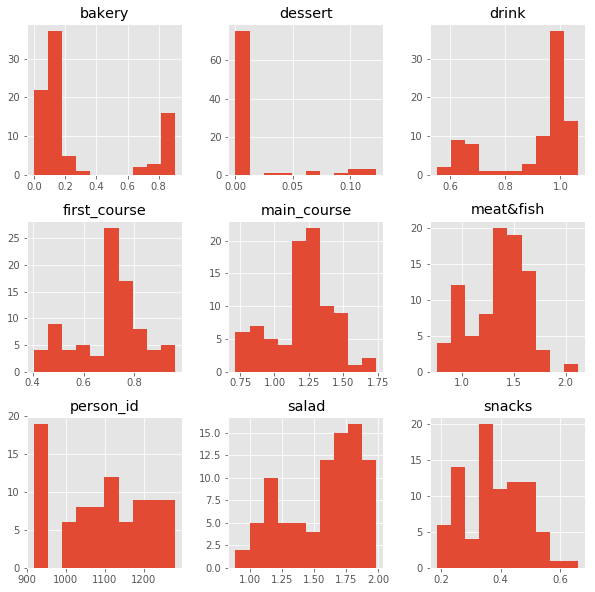

In [13]:
stats_df.groupby(['month', 'day']).mean().hist(figsize=(10, 10))

In [37]:
grouped = stats_df.iloc[:, 2:].groupby(['person_id']).mean()
grouped.describe()

,first_course,main_course,drink,bakery,dessert,snacks,salad,meat&fish
count,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000,2604.000000
mean,0.692152,1.211371,0.888594,0.249746,0.011127,0.382647,1.546392,1.318800
std,0.296207,0.464719,0.497984,0.275655,0.025374,0.506683,0.542394,0.488733
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.518669,0.966245,0.739470,0.044944,0.000000,0.036585,1.169913,1.000000
50%,0.792893,1.107625,0.876818,0.173913,0.000000,0.142081,1.530060,1.217891
75%,0.904887,1.363636,1.000000,0.364541,0.013514,0.545719,1.875000,1.533333
max,1.846154,4.000000,4.000000,3.333333,0.500000,3.000000,4.642857,4.727273


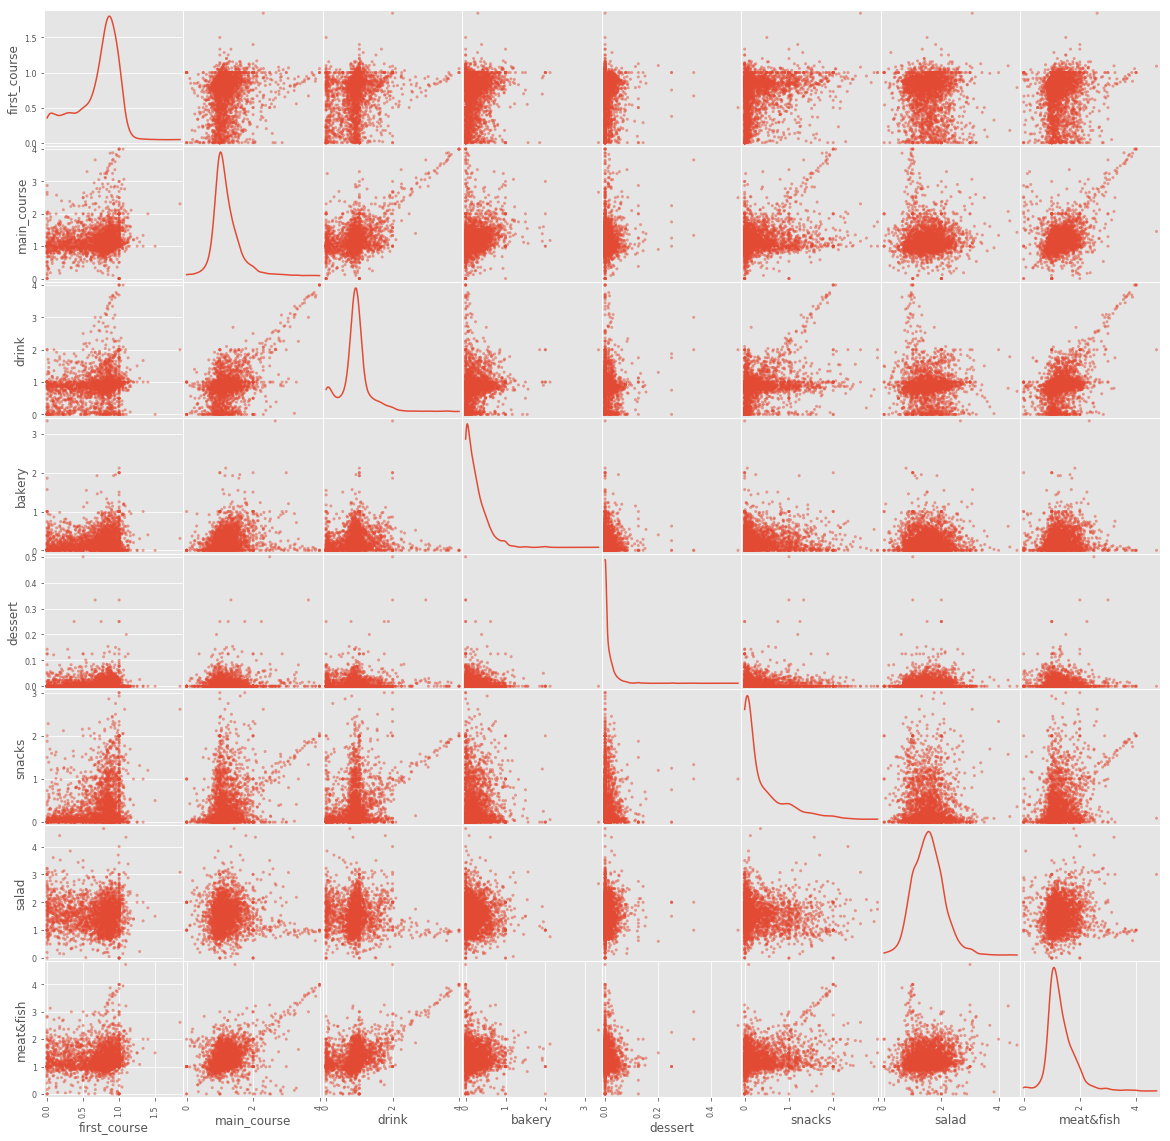

In [38]:
from pandas.plotting import scatter_matrix
grouped = stats_df.iloc[:, 2:].groupby(['person_id']).mean()
scatter_matrix(grouped, diagonal='kde',figsize= (20, 20));